### 1. Import Dependecies

In [54]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

### 2. Load data

In [55]:
df = pd.read_csv('../data/processed/countries_pca_4components.csv')
df.head()
X=df.values

### 3. Helper functions

In [56]:
def pairwise_distances(X):
    """Squared Euclidean distances via broadcasting (O(n^2))"""
    X_norm_sq = np.sum(X**2, axis=1, keepdims=True)
    return X_norm_sq + X_norm_sq.T - 2 * np.dot(X, X.T)

def silhouette_score(X, labels):
    """Safe silhouette score - returns np.nan if <2 clusters"""
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return np.nan
    
    n = len(X)
    distances = pairwise_distances(X)
    silhouette_vals = np.zeros(n)
    
    for i in range(n):
        same_cluster = labels == labels[i]
        if np.sum(same_cluster) > 1:
            a_i = np.mean(distances[i, same_cluster])
        else:
            a_i = 0
        
        b_i = np.inf
        for label in unique_labels:
            if label != labels[i]:
                other_cluster = labels == label
                if np.sum(other_cluster) > 0:
                    b_i = min(b_i, np.mean(distances[i, other_cluster]))
        
        if max(a_i, b_i) > 0:
            silhouette_vals[i] = (b_i - a_i) / max(a_i, b_i)
    
    return np.mean(silhouette_vals)

### 4. K-Means Algorithm implementation

In [57]:
def kmeans_pp_init(X, k):
    X = np.array(X)        # ensure NumPy array
    n, d = X.shape
    centers = np.zeros((k, d))
    centers[0] = X[np.random.randint(n)]
    
    for i in range(1, k):
        distances = np.array([min([np.sum((x - c)**2) for c in centers[:i]]) for x in X])
        probs = distances / distances.sum()
        chosen_idx = np.random.choice(n, p=probs)
        centers[i] = X[chosen_idx]
    
    return centers


def assign_clusters(X, centers):
    """Assign points to nearest center"""
    distances = np.sqrt(((X - centers[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

def update_centers(X, labels, k):
    """Update centers; if empty cluster → reinit to random point"""
    centers = np.zeros((k, X.shape[1]))
    for i in range(k):
        mask = labels == i
        if np.sum(mask) > 0:
            centers[i] = np.mean(X[mask], axis=0)
        else:
            centers[i] = X[np.random.randint(len(X))]
    return centers

def inertia(X, labels, centers):
    """Within-cluster sum of squared errors"""
    total = 0
    for i in range(len(centers)):
        mask = labels == i
        if np.sum(mask) > 0:
            total += np.sum((X[mask] - centers[i])**2)
    return total

def run_kmeans(X, k, max_iter=100, tol=1e-4):
    """Complete K-Means algorithm → centers, labels, inertia_hist"""
    centers = kmeans_pp_init(X, k)
    inertia_hist = []
    
    for iteration in range(max_iter):
        labels = assign_clusters(X, centers)
        current_inertia = inertia(X, labels, centers)
        inertia_hist.append(current_inertia)
        
        new_centers = update_centers(X, labels, k)
        if np.allclose(centers, new_centers, rtol=tol):
            print(f"Converged after {iteration + 1} iterations")
            break
        centers = new_centers
    
    return centers, labels, inertia_hist


Testing different k values...
Converged after 10 iterations
k=2: Inertia=1853.74, Silhouette=0.603
Converged after 7 iterations
k=3: Inertia=1212.80, Silhouette=0.574
Converged after 7 iterations
k=4: Inertia=953.17, Silhouette=0.607
Converged after 6 iterations
k=5: Inertia=775.49, Silhouette=0.511
Converged after 16 iterations
k=6: Inertia=724.27, Silhouette=0.467
Converged after 6 iterations
k=7: Inertia=678.58, Silhouette=0.404
Converged after 14 iterations
k=8: Inertia=616.01, Silhouette=0.423
Converged after 7 iterations
k=9: Inertia=545.61, Silhouette=0.430
Converged after 9 iterations
k=10: Inertia=477.77, Silhouette=0.461


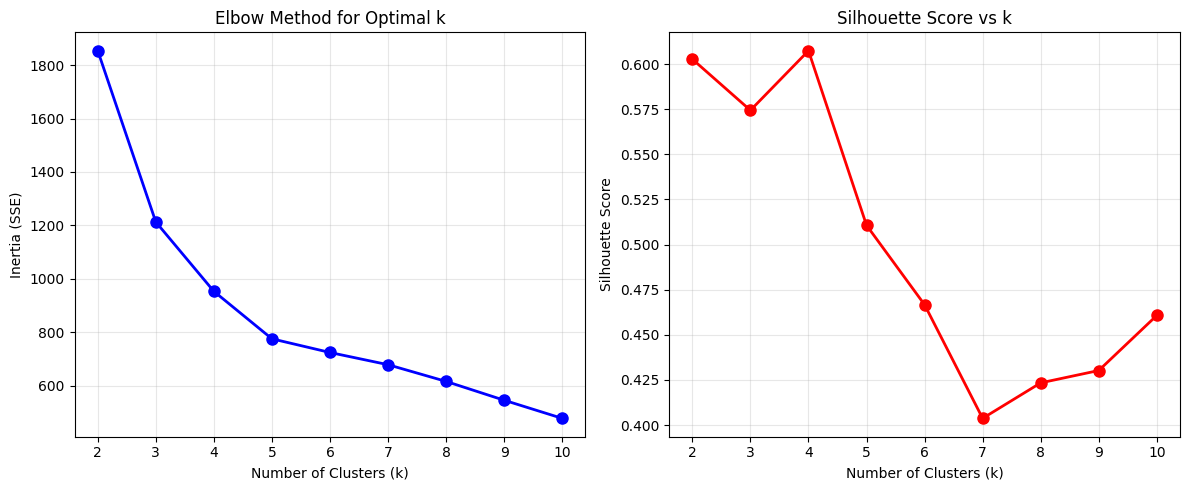


 Best k = 4 (Silhouette = 0.607)
Converged after 11 iterations
Final model: k=4, Inertia=1016.21


In [58]:
# Sweep k in 2..10: run_kmeans → store inertia & silhouette
if 'X' in locals():
    k_range = range(2, 11)
    inertias, silhouettes = [], []
    
    print("Testing different k values...")
    
    for k in k_range:
        centers, labels, inertia_hist = run_kmeans(X, k)
        final_inertia = inertia_hist[-1]
        sil_score = silhouette_score(X, labels)
        
        # Skip if silhouette is invalid
        if not np.isnan(sil_score):
            inertias.append(final_inertia)
            silhouettes.append(sil_score)
            print(f"k={k}: Inertia={final_inertia:.2f}, Silhouette={sil_score:.3f}")
    
    # Plot elbow (inertia vs k) & silhouette vs k
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia (SSE)')
    ax1.set_title('Elbow Method for Optimal k')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(k_range, silhouettes, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score vs k')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # best_k = argmax silhouette; refit once; print summary
    best_k = k_range[np.argmax(silhouettes)]
    print(f"\n Best k = {best_k} (Silhouette = {max(silhouettes):.3f})")
    
    final_centers, final_labels, final_inertia_hist = run_kmeans(X, best_k)
    print(f"Final model: k={best_k}, Inertia={final_inertia_hist[-1]:.2f}")
else:
    print("Data not loaded.")


### 5. Visualizing PCA

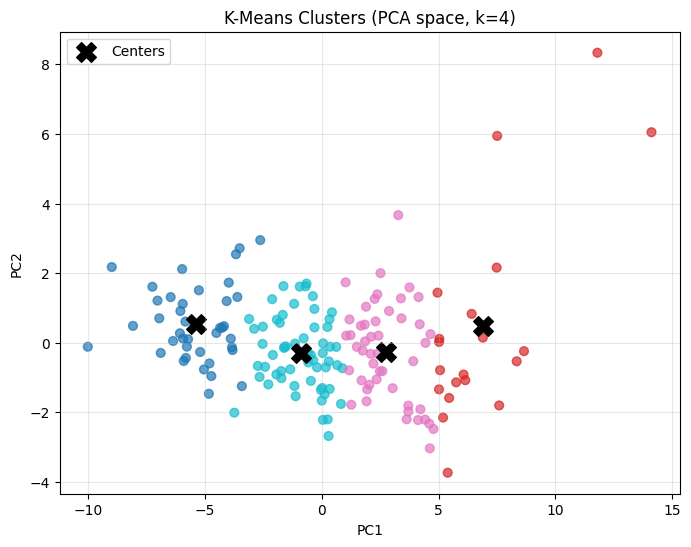

SystemExit: Stopping after this cell

c:\Users\DSYS\anaconda3\envs\foml\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [59]:

X_pca2d = X[:, :2]  

plt.figure(figsize=(8, 6))

plt.scatter(X_pca2d[:, 0], X_pca2d[:, 1], 
            c=final_labels,       
            cmap='tab10',         
            s=40, alpha=0.7)

plt.scatter(final_centers[:, 0], final_centers[:, 1],
            c='black', marker='X', s=200, label='Centers')

plt.title(f'K-Means Clusters (PCA space, k={best_k})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("../artifacts/figures/UMAP_PCA.png", dpi=300)
plt.show()

raise SystemExit("Stopping after this cell")

### 6. Visualizing T-sne

In [ ]:

# # X_tsne = 2D t-SNE coordinates
# X_tsne = df[['tSNE_1', 'tSNE_2']].values

# plt.figure(figsize=(8, 6))

# # Scatter each cluster with a different color
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
#             c=final_labels, cmap='tab10', s=40, alpha=0.7)

# plt.title(f'K-Means Clusters (t-SNE space, k={best_k})')
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')
# plt.grid(alpha=0.3)
# plt.savefig("../artifacts/figures/Tsne_Kmean.png", dpi=300)
# plt.show()


### 7. Cluster evaluation

In [ ]:
df_original = pd.read_csv('../data/raw/Country-data.csv')  # Must contain GDP, Child Mortality, etc.
df_original.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [ ]:
df_original['cluster'] = final_labels
df['cluster'] = final_labels

In [ ]:
# ### Compute Cluster Statistics on Original Features
features = ['gdpp', 'child_mort', 'life_expec']

# Group by cluster to get average feature values
cluster_summary = df_original.groupby('cluster')[features].mean()
print("Cluster Feature Means:\n", cluster_summary)

Cluster Feature Means:
                  gdpp  child_mort  life_expec
cluster                                      
0         1391.300000   99.120000   58.930000
1        52015.000000    5.315000   80.175000
2        16935.625000    9.045833   76.958333
3         4341.559322   31.962712   69.967797


In [ ]:
cluster_label_mapping = {
    0: 'Low-Income',
    1: 'Developed',
    2: 'Emerging (Upper-Middle)',
    3: 'Emerging (Lower-Middle)'
}

In [ ]:
df_original['cluster_label'] = df_original['cluster'].map(cluster_label_mapping)
df['cluster_label'] = df['cluster'].map(cluster_label_mapping)

# ### Inspect Cluster Assignment with Original Values
columns_to_show = ['country', 'cluster', 'gdpp', 'child_mort', 'life_expec','cluster_label']
print(df_original[columns_to_show].head(10))

               country  cluster   gdpp  child_mort  life_expec  \
0          Afghanistan        0    553        90.2        56.2   
1              Albania        3   4090        16.6        76.3   
2              Algeria        3   4460        27.3        76.5   
3               Angola        0   3530       119.0        60.1   
4  Antigua and Barbuda        2  12200        10.3        76.8   
5            Argentina        3  10300        14.5        75.8   
6              Armenia        3   3220        18.1        73.3   
7            Australia        2  51900         4.8        82.0   
8              Austria        1  46900         4.3        80.5   
9           Azerbaijan        3   5840        39.2        69.1   

             cluster_label  
0               Low-Income  
1  Emerging (Lower-Middle)  
2  Emerging (Lower-Middle)  
3               Low-Income  
4  Emerging (Upper-Middle)  
5  Emerging (Lower-Middle)  
6  Emerging (Lower-Middle)  
7  Emerging (Upper-Middle)  
8           